# Final Project

## Project Overview
The purpose of this project is to use OLS linear regression model to test the Capital Asset Pricing Model (CAPM). CAPM is the most popular and recognized asset pricing model derived from the mean-variance analysis. Despite its popularity, there are doubts about if this simple model could actually generate productive results. In this project, we will test one important assumption in CAPM, using OLS linear regression model as an approach. The assumption will be demonstrated in later sections. 

## Project Structure
The project will start with Data Report. In this section, we will discuss the dataset we used in the project and the access to the dataset.

The second section is Data Cleaning and Reformatting. In this section, we will manipulate the dataset to get out interested variables and clean missing values.

The third section is Descriptive Statistical Analysis. In this section, we will display important summary statistics and visualize important variables.

The forth section is Introduction to CAPM. In this section, we will provide a general introduction to this concept and the assumption that we are going to test will also be discussed in this section. 

The fifth section is Regression Analysis. In this section, we will run a regression analysis using OLS and test hypothesis. 

## Data Report
### Data Access
The dataset we used is from Yahoo Finance. We randomly choose eight stocks and we use the S&P500 index as an approximation to the market portfolio. As for the risk-free asset, we choose the 10-year treasury bond as an approximation. Data are accessed using pandas-datareader package. 

### Key Variables
* Daily closing price
    * The daily closing price is the price of a stock when the stock market closes.
* Daily rate of return
    * The daily rate of return on day t of each asset is calculated as the percentage change of closing price on day t from the closing price on day t-1.
This is the only variable that we use in this project, and our interested variables will be derived from the daily rate of return. The specific deriving formula will be discussed when the variable is used.


In [1]:
# Key imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandas_datareader import data
from statsmodels.iolib.summary2 import summary_col, summary_params
from statsmodels.compat import lzip

In [2]:
# Access data and combine to a single DataFrame
symbols = ["NKE", "FDX", "AAPL", "GPS", "TGT", "GE", "UNM", "HQH"]

def read_data(ticker_list,
          start=dt.datetime(1990, 1, 2),
          end=dt.datetime(2019, 12, 31)):
    """
    This function reads in closing price data from Yahoo
    for each tick in the ticker_list.
    """
    ticker = pd.DataFrame()

    for tick in ticker_list:
        prices = data.DataReader(tick, 'yahoo', start, end)
        closing_prices = prices['Close']
        ticker[tick] = closing_prices

    return ticker

# price_df records all daily closing prices of each stock
price_df = read_data(symbols)

In [3]:
# access the s&p500 index
market_df = read_data(["^GSPC"])

# access the 10-year treasury bond
risk_free_df = read_data(['^TNX'])

# merge into a single DataFrame
market_df.columns = ['Market']
risk_free_df.columns = ['Rf']

merged = price_df.merge(market_df, right_index=True, left_index=True)
prices = merged.merge(risk_free_df, right_index=True, left_index=True)

# calculate returns and save as a separate DataFrame
returns = prices.pct_change()

In [4]:
# check missing values
returns.isna().sum()

NKE       1
FDX       1
AAPL      1
GPS       1
TGT       1
GE        1
UNM       1
HQH       1
Market    1
Rf        1
dtype: int64

In [5]:
# drop missing values and scale values for better looking
returns = returns.dropna()
returns = returns*100

returns.head()

,NKE,FDX,AAPL,GPS,TGT,GE,UNM,HQH,Market,Rf
Date,,,,,,,,,,
1990-01-03,-2.222222,1.298701,0.671138,0.950121,0.963394,-0.187265,1.570681,2.597403,-0.258554,0.629719
1990-01-04,-2.045455,-0.769231,0.333332,0.705880,0.190837,-0.562848,1.546392,-1.265823,-0.861299,-0.125153
1990-01-05,3.016241,-2.583979,0.332225,-0.467288,0.190473,-0.943399,1.269036,1.282051,-0.975624,0.125310
1990-01-08,-0.450450,0.265252,0.662249,-1.408451,0.950573,0.571434,-1.002506,1.265823,0.451447,0.375478
1990-01-09,-1.809955,-0.264550,-0.986838,-2.857144,-1.318265,-2.083339,-1.265823,0.000000,-1.178669,0.000000


## Descriptive Statistics

In [6]:
returns.describe()

,NKE,FDX,AAPL,GPS,TGT,GE,UNM,HQH,Market,Rf
count,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000
mean,0.083993,0.053276,0.111689,0.062250,0.062357,0.026312,0.042184,0.026273,0.035330,-0.005170
std,2.033843,1.976417,2.788100,2.561477,2.008945,1.819022,2.418371,1.780390,1.099060,1.661177
min,-19.812664,-14.483406,-51.869158,-21.052632,-16.358464,-12.789118,-38.442822,-22.085890,-9.034978,-15.651016
25%,-0.925223,-0.977199,-1.234565,-1.257637,-0.932839,-0.830368,-0.888325,-0.788498,-0.434999,-0.837317
50%,0.014647,0.000000,0.012437,0.000000,0.000000,0.000000,0.000000,0.000000,0.055487,-0.041168
75%,0.990461,1.014199,1.413425,1.311080,0.988093,0.877196,1.038206,0.855108,0.556089,0.750467
max,14.774282,13.866667,33.227849,27.234491,20.425583,19.703099,22.151904,13.274336,11.580037,15.764256


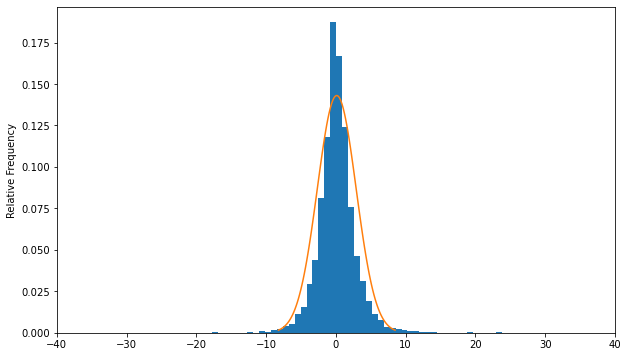

In [7]:
# compare the rate of returns to normal distribution
import scipy.stats as stats

returns['AAPL'].plot.hist(figsize=(10,6),bins=100,weights=np.zeros_like(returns['AAPL']) + 1. / returns['AAPL'].size)
mu = returns['AAPL'].mean()
sigma = returns['AAPL'].std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.ylabel('Relative Frequency')
plt.xlim(-40,40)
plt.show()

In [8]:
returns.cov()

,NKE,FDX,AAPL,GPS,TGT,GE,UNM,HQH,Market,Rf
NKE,4.136515,1.241449,1.217232,1.582109,1.409464,1.221603,1.290881,0.951015,1.071152,0.469986
FDX,1.241449,3.906226,1.305596,1.556883,1.362697,1.471606,1.609714,1.025277,1.216276,0.566884
AAPL,1.217232,1.305596,7.773503,1.531433,1.286406,1.514960,1.275691,1.295243,1.388560,0.597837
GPS,1.582109,1.556883,1.531433,6.561167,2.264797,1.576450,1.645317,1.158890,1.321217,0.539363
TGT,1.409464,1.362697,1.286406,2.264797,4.035860,1.433476,1.435258,1.003280,1.223014,0.415297
GE,1.221603,1.471606,1.514960,1.576450,1.433476,3.308842,1.726522,1.112777,1.395767,0.602047
UNM,1.290881,1.609714,1.275691,1.645317,1.435258,1.726522,5.848516,1.263887,1.456881,0.788670
HQH,0.951015,1.025277,1.295243,1.158890,1.003280,1.112777,1.263887,3.169789,1.029378,0.451313
Market,1.071152,1.216276,1.388560,1.321217,1.223014,1.395767,1.456881,1.029378,1.207933,0.479960
Rf,0.469986,0.566884,0.597837,0.539363,0.415297,0.602047,0.788670,0.451313,0.479960,2.759509


### Analysis
We can see from the descriptive statistical analysis that the rate of returns are not normally distributed. Actually, they are more heavy tailed and more centered at 0 comparing to the normal distribution. One noticable difference is the heavy tail in negative returns.

From the covariance matrix, we can see that the risk-free asset is less correlated with the market portfolio returns, which is in coordinance with our intuition. 

## CAPM 
Formula for CAPM
<h3 align="center">$\overline{r}_i-r_f=\beta_i(\overline{r}_M-r_f)$<h3>


CAPM as a factor model
<h3 align="center">$\overline{r}_i-r_f=\alpha_i + \beta_i( \overline{r}_M-r_f)+\epsilon_i$<h3>

One important assumption in CAPM is that $\alpha_i$ for each stock is zero as well as the error term. This is the assumption that we test in this project. Also, we will show in the section that CAPM can be used as a tool to find the mispriced stocks.

In [9]:
# expected rate of return = risk-free rate + beta * (r_M - r_f)

capm_returns = pd.DataFrame(columns=symbols, index=['beta', 'rf', 'capm'])

for i in symbols:
    r_f = returns['Rf'].mean()
    r_M = returns['Market'].mean()
    beta = returns[i].cov(returns['Market'])/(returns['Market'].var())
    r_hat = r_f + beta*(r_M - r_f)
    
    capm_returns[i] = [beta, r_f, r_hat]


In [10]:
capm_returns

,NKE,FDX,AAPL,GPS,TGT,GE,UNM,HQH
beta,0.886765,1.006907,1.149534,1.093783,1.012485,1.155500,1.206094,0.852181
rf,-0.005170,-0.005170,-0.005170,-0.005170,-0.005170,-0.005170,-0.005170,-0.005170
capm,0.030744,0.035609,0.041386,0.039128,0.035835,0.041627,0.043677,0.029343


In [11]:
actual_mean_r = returns.describe().iloc[1]
capm_returns.append(actual_mean_r[symbols])

,NKE,FDX,AAPL,GPS,TGT,GE,UNM,HQH
beta,0.886765,1.006907,1.149534,1.093783,1.012485,1.155500,1.206094,0.852181
rf,-0.005170,-0.005170,-0.005170,-0.005170,-0.005170,-0.005170,-0.005170,-0.005170
capm,0.030744,0.035609,0.041386,0.039128,0.035835,0.041627,0.043677,0.029343
mean,0.083993,0.053276,0.111689,0.062250,0.062357,0.026312,0.042184,0.026273


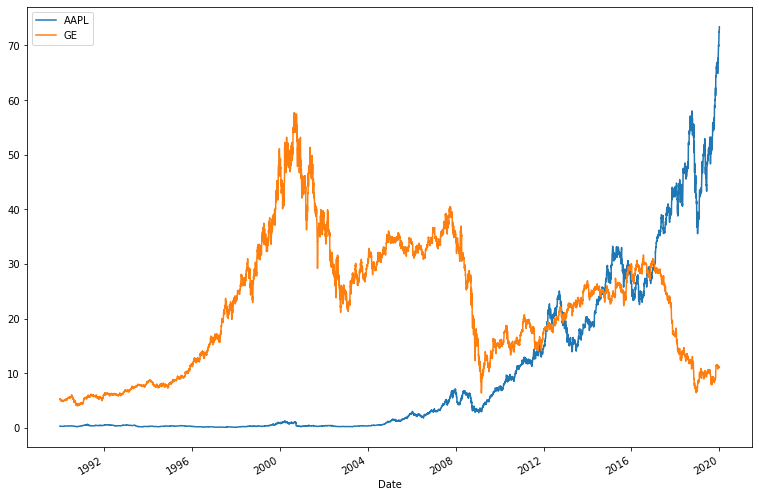

In [12]:
price_df[['AAPL','GE']].plot(figsize=(13,9))
plt.show()

## Regression Analysis

In [13]:
returns['rM-rf'] = returns['Market'] - returns['Rf']

In [14]:
x = returns['rM-rf']
models = []
results =[]

for i in symbols:
    y = returns[i] - returns['Rf']
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    result = model.fit()
    models.append(model)
    results.append(result)

In [15]:
print(summary_col(results, model_names = symbols, stars=True))


                  NKE       FDX       AAPL      GPS       TGT        GE       UNM       HQH   
----------------------------------------------------------------------------------------------
const          0.0504**  0.0190    0.0755*** 0.0262    0.0260    -0.0099   0.0077    -0.0070  
               (0.0207)  (0.0189)  (0.0288)  (0.0262)  (0.0193)  (0.0152)  (0.0235)  (0.0176) 
rM-rf          0.9578*** 0.9739*** 1.0209*** 1.0179*** 1.0265*** 1.0219*** 0.9801*** 0.9502***
               (0.0119)  (0.0109)  (0.0166)  (0.0151)  (0.0111)  (0.0087)  (0.0136)  (0.0101) 
R-squared      0.4633    0.5156    0.3357    0.3781    0.5313    0.6456    0.4109    0.5402   
R-squared Adj. 0.4632    0.5156    0.3356    0.3780    0.5312    0.6456    0.4109    0.5401   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


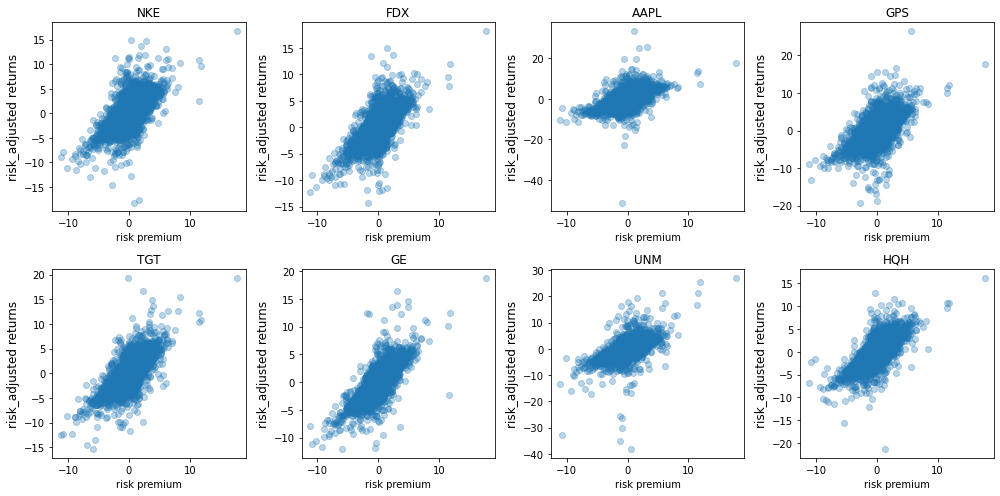

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for inter__, ax in enumerate(axes.flatten()):
    index_name = returns.columns[inter__]
    ax.scatter(returns['rM-rf'], returns[index_name]-returns['Rf'], alpha=0.3)
    ax.set_ylabel('risk_adjusted returns', fontsize=12)
    ax.set_xlabel('risk premium')
    ax.set_title(index_name)
plt.tight_layout()

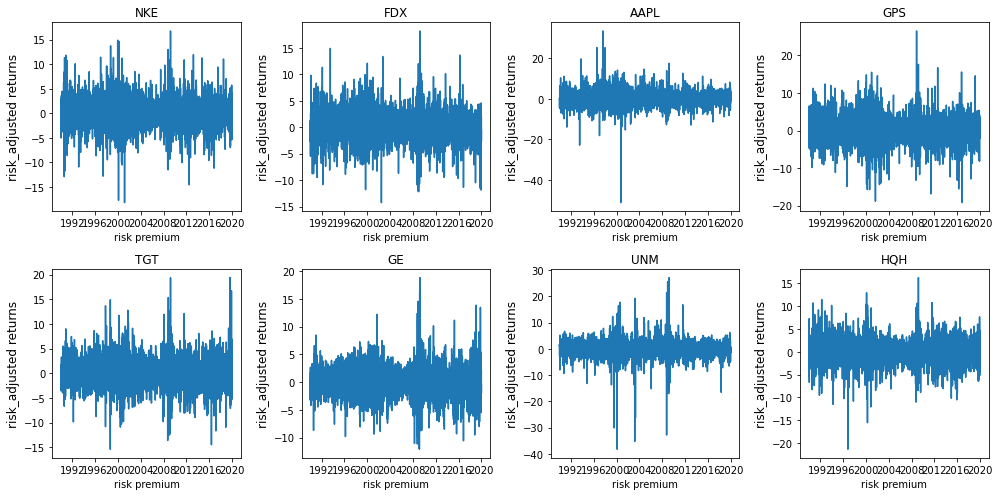

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for inter__, ax in enumerate(axes.flatten()):
    index_name = returns.columns[inter__]
    ax.plot(returns[index_name]-returns['Rf'])
    ax.set_ylabel('risk_adjusted returns', fontsize=12)
    ax.set_xlabel('risk premium')
    ax.set_title(index_name)
plt.tight_layout()

### Analysis
From the regression results, we can see that the constant coefficient of Nike and Apple are statistically significant at 0.05 and 0.01 level of significance respectively. This means that we should reject our null hypothesis which is alpha is equal to zero for Nike and Apple. This means that this assumption of CAPM does not always hold. If we take a closer look at the distribution of these two stocks' rate of returns, we can see that Apple's stock's rate of returns have a dramatic outlier that affect our regression results dramatically. This explains the significance of the constant coefficient. However, we are not able to visually see any difference from Nike's distribution. Rigorous analysis on this topic requires more in-depth analysis on test-statistics that reflect the impact of outliers on the regression result. 

Another noticable discrepency is the different beta we obtained from the regression model. In theory, the beta should remain the same as we calculated in the previous section. This can be explained by the covariance of the risk-free rate of returns. In CAPM, the risk-free rate of return is considered as a constant, which means the covariance of it and other variables is always zero. However, in the regression model (factor model), the risk-free rate of return becomes a random variables that is correlated with others. Therefore, we could expect the coefficient of the dependent variable to change. 

## Discussion and Conclusion
From previous analysis, we can see that although CAPM is not an ideal robust model that always holds its assumptions in different cases, its function as a pricing model that could potentially discover the mispriced assets is significant. 

Our analysis includes only eight randomly chosen assets and we use approximation to both the market asset and the risk_free asset, which means there are errors and the results could be potentially bias. This requires furthur proof and more rigorous analysis using different evaluation metrices. However, it does serve as a good starting point to evaluate CAPM and its funcionality. It is always better to challenge the norm than passively accepting it. 

Some suggestions for the future research would be to expand the range of assets. This means to include more assets from more diverse industries and time spans. Also, future research should emphasize on the better approximation to the market portfolio, such as including other kinds of assets like real estates, natural resources and so on. This helps minimize the error produced in the preparation stage. 